# Building a Robot Judge
## ETH Zurich, Spring 2019

## Problem Set 2

Author: Philipp Nikolaus

## 1. Environment

In [1]:
import json
import os
import pickle
import random
import string
from collections import Counter
from itertools import groupby
from string import punctuation

import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import spacy
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.tfidfmodel import TfidfModel
from keras.layers import Activation, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import l2
from linearmodels import IV2SLS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
from scipy import sparse
from sklearn.calibration import calibration_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import (ElasticNet, LinearRegression,
                                  LogisticRegression)
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score,
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import (GridSearchCV, KFold, StratifiedKFold,
                                     StratifiedShuffleSplit, cross_val_predict,
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm import tqdm
from wordcloud import WordCloud

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]


## 2. Data prep

In [2]:
n_samples = None # use only a subset of the available data for computational reasons
seed = 42
random.seed(seed)

# meta_data = pd.read_csv('./data/case_metadata.csv')
# meta_data = meta_data.drop_duplicates(subset=["caseid"],keep="first")
# meta_data = meta_data.rename(index=meta_data.caseid).drop("caseid", axis=1).to_dict(orient="index")

# response = pd.read_csv('./data/case_reversed.csv')
# response = {row["caseid"]: row["case_reversed"] for i, row in response.iterrows()}

In [3]:
# meta_data['X3JGGO']

In [4]:
with open("./data/cases_preprocessed_full.pkl", "rb") as f:
    data = pickle.load(f)

In [6]:
# for case_id, case in tqdm(data.items()):
#     data[case_id]["case_reversed"] = meta_data[case_id]["case_reversed"]
#     data[case_id]["judge_id"] = meta_data[case_id]["judge_id"]
#     data[case_id]["log_cites"] = meta_data[case_id]["log_cites"]

100%|██████████| 4236/4236 [00:00<00:00, 377741.51it/s]


In [5]:
print(list(data.keys())[:20])

['X3H0E7', 'X4AKRO', 'X19E92S003', 'X3GBO8', 'X3ILN5', 'X3IJNV', 'X3BF7F', 'X391D1', 'X4A2GQ', 'X4A1L0', 'X353TJ', 'X36G10', 'X3SL02', 'X37OSS', 'X3CCEO', 'X41ESC', 'X16LL7S003', 'X3SPML', 'X44HV6', 'XABNR8']


In [14]:
print(data['X3GGN6'].keys())

dict_keys(['filename', 'year', 'doc_raw', 'x_republican', 'case_reversed', 'judge_id', 'log_cites', 'doc_spacy', 'doc_clean'])


In [15]:
def normalize_token(token):
    """Normalize Token. Get Lemma (base form) and remove any punctuation
    """
    lemma = token.lemma_.lower().strip()
    nopunct = lemma.translate(str.maketrans('', '', string.punctuation))
    return nopunct

def keep_token(token):
    keep_token = not token.is_punct and not token.is_space and not token.is_stop and not token.like_num
    return keep_token

In [16]:
## function to take in a preprocessed document and return a list of all lemmatized 3-grams.
## Only 3-grams within the same sentence are considered.

trigram_features = []
case_trigrams = {}

for case_id, case in tqdm(data.items()):
    trigrams = []
    tokens = [(normalize_token(tok), tok.pos_) for tok in case["doc_spacy"] if keep_token(tok)]
    for i, (tok, pos) in enumerate(tokens):
        if (pos=="NOUN") & (i >= 2):

            feature = "_".join([tok[0] for tok in tokens[i-2:i+1]])
            trigram_features.append(feature)
            trigrams.append(feature)
    
    case_trigrams[case_id] = {"total_count": len(trigrams), "trigram_counts": dict(Counter(trigrams))}

trigram_count = Counter(trigram_features)
top_trigrams = [trigram[0] for trigram in trigram_count.most_common(1000)]

100%|██████████| 5762/5762 [01:04<00:00, 89.73it/s]


In [17]:
trigram_data = {}
for case_id, case_counts in case_trigrams.items():
    features = {}
    for trigram in top_trigrams:
        if case_counts["total_count"] > 0:
            features[trigram] = case_counts["trigram_counts"].get(trigram, 0) / case_counts["total_count"]
        else:
            features[trigram] = 0
    trigram_data[case_id] = features

In [123]:
trigram_df = pd.DataFrame.from_dict(trigram_data, orient="index")

cases_reversed = {}
for case_id, case in data.items():
    if not case["case_reversed"] in cases_reversed.keys():
        cases_reversed[case["case_reversed"]] = [case_id]
    else:
        cases_reversed[case["case_reversed"]].append(case_id)


cases_sampled = cases_reversed[0] + random.sample(cases_reversed[1], 2118)
random.shuffle(cases_sampled)

trigram_df = trigram_df.loc[cases_sampled,:]

In [124]:
arr = sparse.csr_matrix(trigram_df.values)
arr_norm = StandardScaler(with_mean=False).fit_transform(arr)

trigram_df = pd.DataFrame(arr_norm.toarray(), columns=trigram_df.columns, index=trigram_df.index)

# let's check that it worked
trigram_df.apply(lambda col: np.std(col), axis=0)

number_number_number           1.0
number_sct_number              1.0
number_number_sct              1.0
number_us_number               1.0
us_number_number               1.0
                              ... 
law_enforcement_official       1.0
lake_city_market               1.0
number_srep_number             1.0
number_approximately_number    1.0
question_present_appeal        1.0
Length: 1000, dtype: float64

In [125]:
# the trigram dataframe will be used as the training data
trigram_df.head()

number_number_number  number_sct_number  number_number_sct  \
X40KM2              0.894143           0.508216           0.538890   
X41JJC              0.993492           0.878399           0.931415   
X28DA9              0.000000           0.000000           0.000000   
XGKE8Q              1.579965           1.676316           1.650527   
X41P9D              0.140197           0.000000           0.000000   

        number_us_number  us_number_number  sct_number_number  \
X40KM2          0.560342          0.589877           0.618216   
X41JJC          0.968492          1.019540           1.068521   
X28DA9          0.000000          0.000000           0.000000   
XGKE8Q          1.452195          1.459251           1.238050   
X41P9D          0.000000          0.000000           0.000000   

        number_f2d_number  number_led2d_number  led2d_number_number  \
X40KM2           0.539102             0.000000             0.000000   
X41JJC           0.399335             0.000000             0.000000   
X28DA9           0.075693             0.000000             0.000000   
XGKE8Q           0.190521             1.669094             1.763288   
X41P9D           0.000000             0.000000             0.000000   

        f2d_number_number  ...  state_court_judgment  s_w_number  \
X40KM2           0.000000  ...                   0.0         0.0   
X41JJC           1.279962  ...                   0.0         0.0   
X28DA9           0.000000  ...                   0.0         0.0   
XGKE8Q           0.610662  ...                   0.0         0.0   
X41P9D           0.000000  ...                   0.0         0.0   

        number_9th_cir1994  comp_st_number  cir_number_curiam  \
X40KM2                 0.0        0.000000                0.0   
X41JJC                 0.0        0.000000                0.0   
X28DA9                 0.0        7.718444                0.0   
XGKE8Q                 0.0        0.000000                0.0   
X41P9D                 0.0        0.000000                0.0   

        law_enforcement_official  lake_city_market  number_srep_number  \
X40KM2                       0.0               0.0            0.000000   
X41JJC                       0.0               0.0            0.000000   
X28DA9                       0.0               0.0            0.000000   
XGKE8Q                       0.0               0.0            3.551313   
X41P9D                       0.0               0.0            0.000000   

        number_approximately_number  question_present_appeal  
X40KM2                          0.0                      0.0  
X41JJC                          0.0                      0.0  
X28DA9                          0.0                      0.0  
XGKE8Q                          0.0                      0.0  
X41P9D                          0.0                      0.0  

[5 rows x 1000 columns]

## 4. Cross_val_predict()

In [129]:
## based on the cases in the training data, we collect the respective response (case_reversed)

y = [data[case_id]["case_reversed"] for case_id in cases_sampled]

In [130]:
## randomly splitting the data into training and test set

X = trigram_df
X_train, X_test, y_train, y_test = train_test_split(X_trigram, y, test_size=0.3, random_state=seed, stratify=y)

In [131]:
clf = LogisticRegression(C=0.0001, penalty="l2")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

cv_preds = cross_val_predict(
    estimator=clf,
    X=X, y=y, cv=cv,
    method="predict_proba"
)

In [132]:
cv_preds[:10]

array([[0.48319737, 0.51680263],
       [0.54492667, 0.45507333],
       [0.52396663, 0.47603337],
       [0.50097543, 0.49902457],
       [0.51351647, 0.48648353],
       [0.52453486, 0.47546514],
       [0.51535131, 0.48464869],
       [0.51778296, 0.48221704],
       [0.47500347, 0.52499653],
       [0.50664651, 0.49335349]])

In [133]:
confusion_matrix(y, np.argmax(cv_preds, axis=1))

array([[1165,  953],
       [ 931, 1187]])

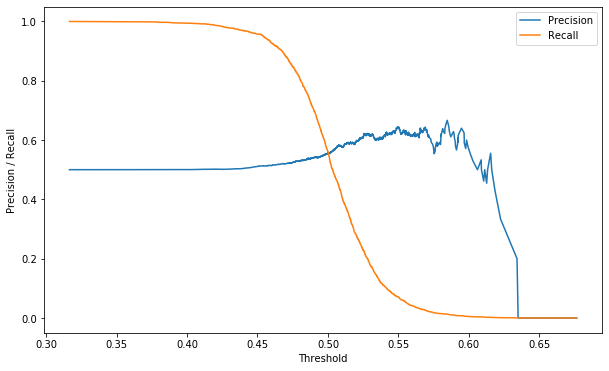

In [134]:
precisions, recalls, thresholds = precision_recall_curve(y, cv_preds[:,1])

import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.legend()

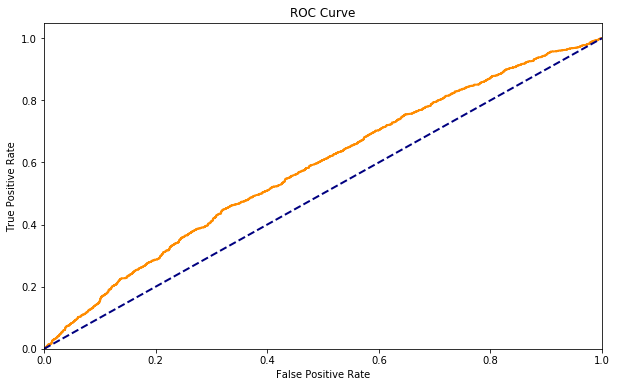

In [135]:
fpr, tpr, _ = roc_curve(y, cv_preds[:,1])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

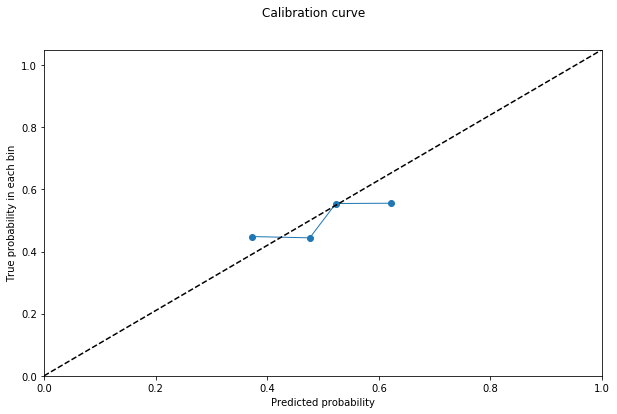

In [136]:
logreg_y, logreg_x = calibration_curve(y, cv_preds[:,1], n_bins=10)

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1)

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle="--")
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration curve')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

## 5. Log_cites

In [30]:
## get log_cites

log_cites_cases = [key for key, value in data.items() if not np.isnan(value["log_cites"])]

In [102]:
X_log_cites = pd.DataFrame.from_dict(trigram_data, orient="index").loc[log_cites_cases,:].copy()

scaler = StandardScaler(with_mean=False)
X_log_cites = scaler.fit_transform(X_log_cites)

In [103]:
log_cites = [data[case_id]["log_cites"] for case_id in log_cites_cases]

In [106]:
## cross_val_pred EN model

elasticnet = ElasticNet(alpha=3, l1_ratio=0)

en_preds = cross_val_predict(
    elasticnet, 
    X_log_cites, 
    log_cites, 
    verbose=1,
    cv=3,
    method="predict"
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished


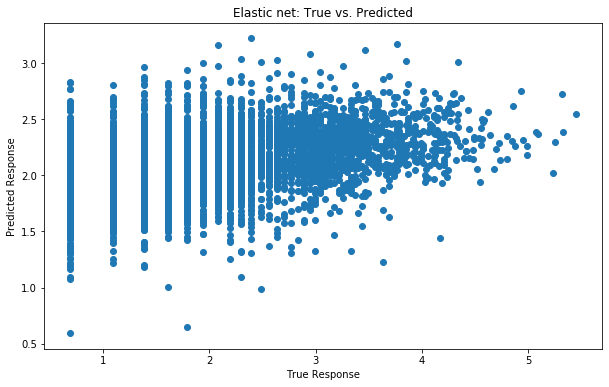

In [107]:
plt.figure()
plt.scatter(log_cites, en_preds)
plt.xlabel('True Response')
plt.ylabel('Predicted Response')
plt.title("Elastic net: True vs. Predicted")
plt.show()

## 6. Judge citations

In [108]:
judge_citations = {}

for case_id in log_cites_cases:
    judge_id = data[case_id]["judge_id"]
    cites = data[case_id]["log_cites"]

    if np.isnan(judge_id):
        continue

    if judge_id in judge_citations.keys():
        judge_citations[judge_id]["case_cites"].append(cites)
    else:
        judge_citations[judge_id] = {
            "case_cites": [cites]
        }

for judge_id in judge_citations.keys():
    judge_citations[judge_id]["mean_cites"] = np.mean(judge_citations[judge_id]["case_cites"])

In [109]:
for case_id, case in data.items():
    try:
        data[case_id]["judge_mean_cites"] = judge_citations[case["judge_id"]]["mean_cites"]
    except:
        data[case_id]["judge_mean_cites"] = np.nan        

In [110]:
X_judge_cites = pd.DataFrame.from_dict(data, orient="index")
X_judge_cites = X_judge_cites[["year", "log_cites", "judge_mean_cites", "case_reversed"]]
X_judge_cites = X_judge_cites.dropna(axis=0, how="any")

X_judge_cites.year = X_judge_cites.year.astype(str)

In [111]:
X_judge_cites.head()

year  log_cites  judge_mean_cites  case_reversed
X4AKRO      1937   2.079442          2.128235              1
X19E92S003  2008   2.708050          2.062328              1
X3ILN5      1996   1.791759          1.822590              1
X3BF7F      1941   1.945910          2.230570              1
X391D1      1994   1.386294          2.700055              1

In [112]:
## fit model as described in question text. response: case_reversed, exogenous var: year, 
## endogenous var: log_cites, instrument: avg_cites (judge effect)

mod_iv = IV2SLS.from_formula(
    formula='case_reversed ~ 1 + year + [log_cites ~ judge_mean_cites]', 
    data=X_judge_cites
)
res_iv = mod_iv.fit()

mod = IV2SLS.from_formula(
    formula='case_reversed ~ 1 + log_cites', 
    data=X_judge_cites
)
res = mod.fit()

res_iv

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          case_reversed   R-squared:                      0.0568
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0371
No. Observations:                4399   F-statistic:                    298.90
Date:                Mon, Sep 14 2020   P-value (F-stat)                0.0000
Time:                        18:32:38   Distribution:                 chi2(90)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
================================================================================
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept        0.5335     0.2958     1.8035     0.0713     -0.0463      1.1133
year[T.1925]     0.1795     0.3111     0.5769     0.5640     -0.4302      0.7891
year[T.1926]     0.1665     0.3116     0.5344     0.5931     -0.4442      0.7773
year[T.1927]     0.4165     0.3060     1.3611     0.1735     -0.1833      1.0162
year[T.1928]     0.2722     0.3144     0.8656     0.3867     -0.3441      0.8885
year[T.1929]     0.0551     0.3089     0.1784     0.8584     -0.5503      0.6605
year[T.1930]     0.1282     0.3075     0.4168     0.6768     -0.4745      0.7309
year[T.1931]    -0.0058     0.3072    -0.0189     0.9850     -0.6079      0.5963
year[T.1932]    -0.0160     0.3018    -0.0529     0.9578     -0.6074      0.5755
year[T.1933]     0.1642     0.3048     0.5387     0.5901     -0.4332      0.7616
year[T.1934]     0.0854     0.3018     0.2829     0.7772     -0.5062      0.6770
year[T.1935]    -0.0619     0.3034    -0.2041     0.8383     -0.6566      0.5327
year[T.1936]     0.1203     0.3029     0.3972     0.6912     -0.4734      0.7140
year[T.1937]     0.2781     0.3025     0.9194     0.3579     -0.3148      0.8711
year[T.1938]    -0.0018     0.3021    -0.0061     0.9951     -0.5939      0.5903
year[T.1939]     0.2423     0.3012     0.8045     0.4211     -0.3480      0.8326
year[T.1940]     0.2276     0.2997     0.7594     0.4476     -0.3599      0.8151
year[T.1941]     0.2974     0.3026     0.9829     0.3257     -0.2956      0.8904
year[T.1942]     0.1968     0.3023     0.6508     0.5152     -0.3958      0.7893
year[T.1943]     0.1852     0.3029     0.6114     0.5409     -0.4085      0.7789
year[T.1944]     0.2043     0.3025     0.6753     0.4995     -0.3886      0.7972
year[T.1945]     0.2177     0.3038     0.7167     0.4736     -0.3777      0.8131
year[T.1946]     0.1303     0.3036     0.4290     0.6679     -0.4649      0.7254
year[T.1947]     0.2825     0.3036     0.9307     0.3520     -0.3124      0.8775
year[T.1948]     0.2556     0.3017     0.8472     0.3969     -0.3357      0.8470
year[T.1949]     0.2844     0.3053     0.9318     0.3514     -0.3139      0.8828
year[T.1950]     0.3151     0.3016     1.0448     0.2961     -0.2761      0.9063
year[T.1951]     0.1276     0.3045     0.4189     0.6753     -0.4693      0.7244
year[T.1952]     0.2604     0.3050     0.8537     0.3933     -0.3374      0.8581
year[T.1953]     0.2409     0.3051     0.7897     0.4297     -0.3570      0.8388
year[T.1954]     0.3450     0.3034     1.1374     0.2554     -0.2495      0.9396
year[T.1955]     0.2712     0.3022     0.8975     0.3694     -0.3211      0.8635
year[T.1956]     0.2397     0.3002     0.7986     0.4245     -0.3486      0.8281
year[T.1957]     0.2543     0.3029     0.8396     0.4012     -0.3394      0.8479
year[T.1958]     0.3044     0.3009     1.0118     0.3117     -0.2853      0.8942
year[T.1959]     0.3672     0.3005     1.2219     0.2218     -0.2218      0.9561
year[T.1960]     0.3141     0.3027     1.0377     0.2994     -0.2792      0

In [113]:
print("IV Results:")
print(f"-- coefficient: {res_iv.params['log_cites']}")
print(f"-- std. error: {res_iv.std_errors['log_cites']}")
print(f"-- p-value: {res_iv.pvalues['log_cites']}")
print("")
print("Non-IV Results:")
print(f"-- coefficient: {res.params['log_cites']}")
print(f"-- std. error: {res.std_errors['log_cites']}")
print(f"-- p-value: {res.pvalues['log_cites']}")

IV Results:
-- coefficient: -0.11563767747941611
-- std. error: 0.019233448095575385
-- p-value: 1.8288492942275525e-09

Non-IV Results:
-- coefficient: -0.047383737921212754
-- std. error: 0.007865649832023036
-- p-value: 1.700162233220226e-09


## 7. LDA and Word Clouds

In [114]:
data["X47POH"]["doc_clean"][:20]

['stephens',
 'circuit',
 'judge',
 'appeal',
 'judgment',
 'jury',
 'verdict',
 'favor',
 'plaintiff',
 'appellee',
 'damage',
 'result',
 'death',
 'husband',
 'employee',
 'defendant',
 'appellant',
 'railroad',
 'company',
 'fatally']

In [117]:
## tfidf features from lemmatized case strings

dictionary = corpora.Dictionary([case["doc_clean"] for case in data.values()])
dictionary.filter_n_most_frequent(5)
cbow_corpus = [dictionary.doc2bow(case["doc_clean"]) for case in data.values()]

# tfidf_mod = TfidfModel(cbow_corpus)
# tfidf_corpus = [tfidf_mod[case_cbow] for case_cbow in cbow_corpus]

In [118]:
lda = LdaModel(
    cbow_corpus, 
    num_topics=3, 
    id2word = dictionary, 
    passes=3,
    random_state=seed
)
lda.show_topics(formatted=False)

[(0,
  [('state', 0.011747383),
   ('sct', 0.0108251115),
   ('us', 0.0098458305),
   ('district', 0.008258298),
   ('states', 0.006657107),
   ('united', 0.006648594),
   ('defendant', 0.0055225585),
   ('law', 0.0053491113),
   ('trial', 0.0049668755),
   ('led2d', 0.004945166)]),
 (1,
  [('act', 0.008168041),
   ('company', 0.005859347),
   ('section', 0.005469623),
   ('co', 0.0053532203),
   ('commission', 0.004661617),
   ('order', 0.004481054),
   ('tax', 0.0043381723),
   ('state', 0.004313172),
   ('board', 0.0043113534),
   ('f2d', 0.0039236858)]),
 (2,
  [('district', 0.006892322),
   ('state', 0.0058298665),
   ('sct', 0.0056855287),
   ('act', 0.0055662813),
   ('us', 0.0051642773),
   ('f2d', 0.0047203368),
   ('claim', 0.0045000482),
   ('defendant', 0.004436267),
   ('states', 0.004234775),
   ('government', 0.004233058)])]

In [120]:
## fit LDA for different # of topics

lda_models = {}
for n_topics in tqdm(range(2,6)):
    lda = LdaModel(
        cbow_corpus, 
        num_topics=n_topics, 
        id2word = dictionary, 
        passes=3,
        random_state=seed
    )
    lda_models[n_topics] = lda

100%|██████████| 4/4 [02:13<00:00, 33.49s/it]


In [121]:
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# helper function for coloring word clouds
def plot_wordclouds(lda_model):

    for i, weights in lda_model.show_topics(
            num_topics=-1, num_words=100, formatted=False
    ):

        wc = WordCloud(
            background_color="white", 
            ranks_only=False, 
            max_font_size=200,
            color_func=lambda *args, **kwargs: cols[i],
            prefer_horizontal=1.0,
            height=800,
            width=1200
        ).generate_from_frequencies(dict(weights))

        plt.clf()
        plt.imshow(wc,interpolation="bilinear")
        plt.axis("off")
        plt.show()

LDA Model: 2 topics


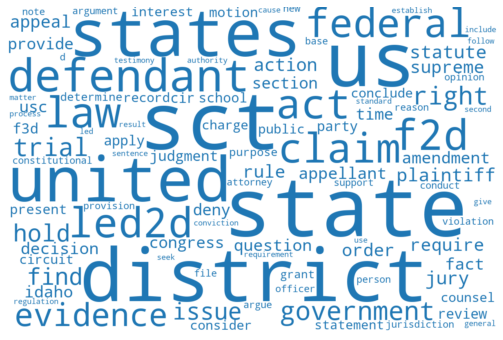

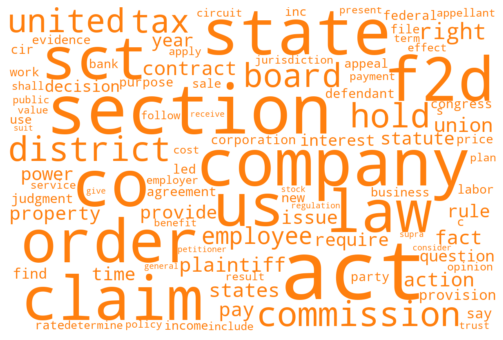


LDA Model: 3 topics


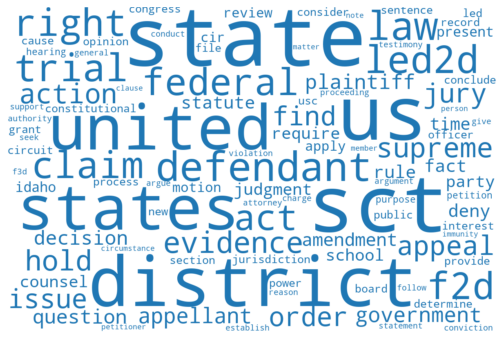

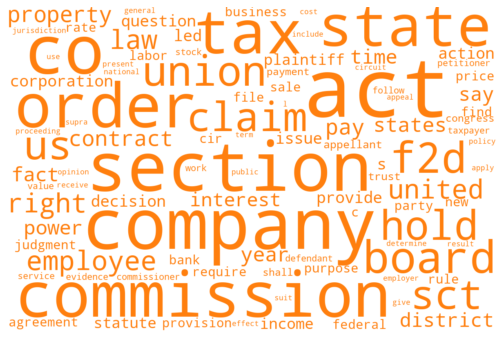

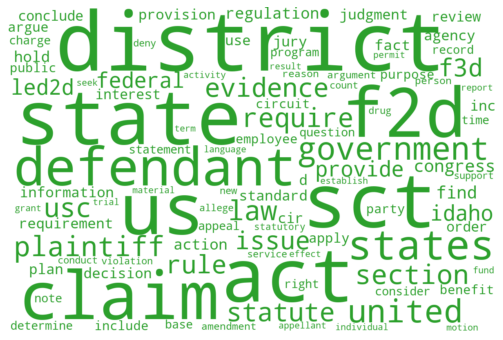


LDA Model: 4 topics


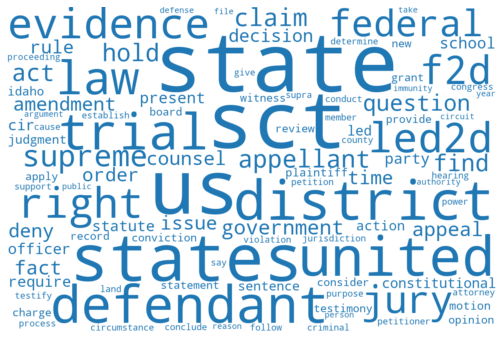

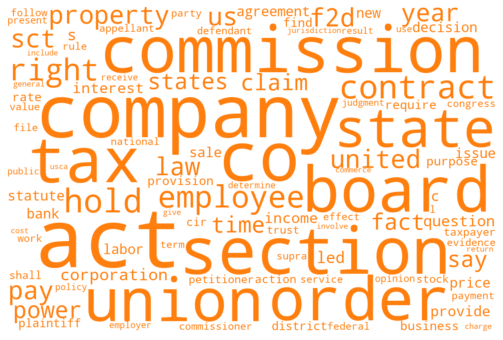

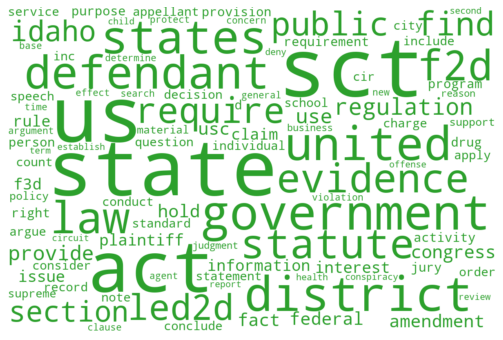

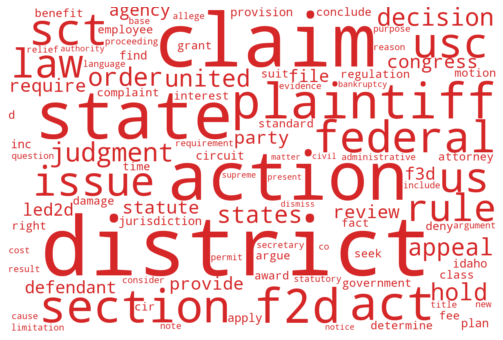


LDA Model: 5 topics


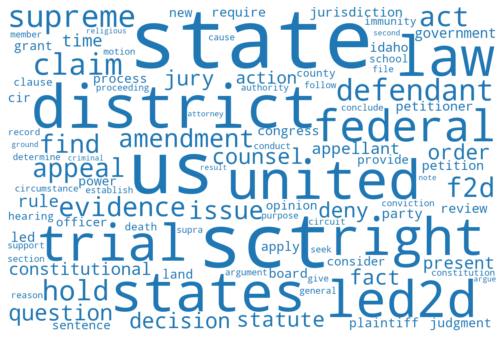

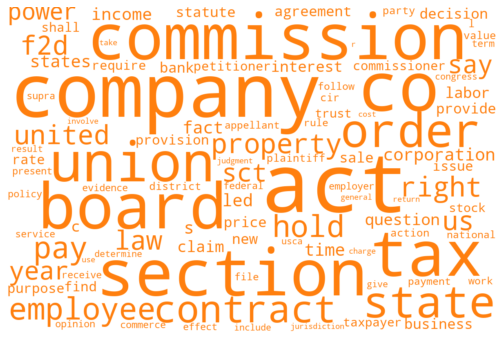

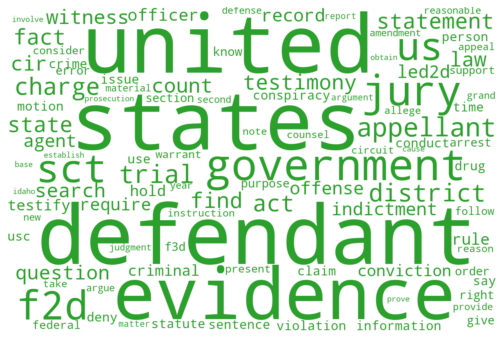

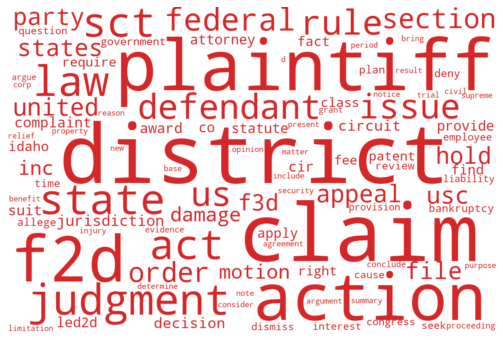

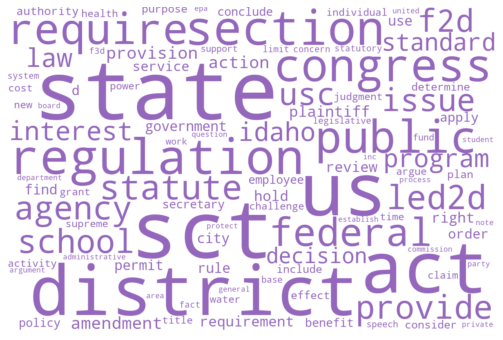

In [122]:
for num_topics, lda_model in lda_models.items():
    print(f"LDA Model: {num_topics} topics")
    plot_wordclouds(lda_model)
    print("========================================================================")
    print("")

## 8. Linear Regression vs. DNN
### 8.1 Keras Logistic Regression

In [151]:
X_train, X_test, y_train, y_test = train_test_split(trigram_df, np.array(y), test_size=0.3, random_state=seed, stratify=y)

In [152]:
keras_logreg = Sequential()
keras_logreg.add(
    Dense(1, input_dim=1000, activation=None)
)
keras_logreg.add(Activation("sigmoid"))

keras_logreg.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

keras_logreg.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 1001      
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [153]:
logreg_hist = keras_logreg.fit(
    X_train, y_train,
    epochs=5, 
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/5
93/93 [==============================] - 0s 2ms/step - loss: 0.8611 - accuracy: 0.5150 - val_loss: 0.7990 - val_accuracy: 0.5382
Epoch 2/5
93/93 [==============================] - 0s 1ms/step - loss: 0.7509 - accuracy: 0.5599 - val_loss: 0.7784 - val_accuracy: 0.5500
Epoch 3/5
93/93 [==============================] - 0s 1ms/step - loss: 0.6831 - accuracy: 0.6047 - val_loss: 0.7698 - val_accuracy: 0.5586
Epoch 4/5
93/93 [==============================] - 0s 1ms/step - loss: 0.6372 - accuracy: 0.6354 - val_loss: 0.7750 - val_accuracy: 0.5570
Epoch 5/5
93/93 [==============================] - 0s 1ms/step - loss: 0.6064 - accuracy: 0.6610 - val_loss: 0.7771 - val_accuracy: 0.5531


### 8.2 Keras DNN

In [154]:
keras_dnn = Sequential()

for i, n_units in enumerate([1024, 1024]):
    if i == 0:
        keras_dnn.add(
            Dense(n_units, input_dim=1000, activation=None)
        )
    else:
        keras_dnn.add(
            Dense(n_units, activation=None)
        )
    keras_dnn.add(BatchNormalization())
    keras_dnn.add(Activation("relu"))
    keras_dnn.add(Dropout(0.95))

keras_dnn.add(Dense(1, activation=None))
keras_dnn.add(Activation("sigmoid"))

keras_dnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

keras_dnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              1025024   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation_4 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_5 (Activation)    (None, 1024)             

In [155]:
dnn_hist = keras_dnn.fit(
    X_train, y_train,
    epochs=50, 
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
93/93 [==============================] - 1s 14ms/step - loss: 1.7167 - accuracy: 0.5008 - val_loss: 0.7265 - val_accuracy: 0.5193
Epoch 2/50
93/93 [==============================] - 1s 13ms/step - loss: 1.4880 - accuracy: 0.5029 - val_loss: 0.7034 - val_accuracy: 0.5161
Epoch 3/50
93/93 [==============================] - 1s 13ms/step - loss: 1.2436 - accuracy: 0.5005 - val_loss: 0.6950 - val_accuracy: 0.5295
Epoch 4/50
93/93 [==============================] - 1s 13ms/step - loss: 1.0747 - accuracy: 0.5096 - val_loss: 0.6903 - val_accuracy: 0.5319
Epoch 5/50
93/93 [==============================] - 1s 13ms/step - loss: 0.9490 - accuracy: 0.5062 - val_loss: 0.6897 - val_accuracy: 0.5421
Epoch 6/50
93/93 [==============================] - 1s 13ms/step - loss: 0.8492 - accuracy: 0.5049 - val_loss: 0.6919 - val_accuracy: 0.5319
Epoch 7/50
93/93 [==============================] - 1s 13ms/step - loss: 0.8093 - accuracy: 0.5110 - val_loss: 0.6918 - val_accuracy: 0.5397
Epoch 8/50
93